
# StreamReader Basic Usages

**Author**: [Moto Hira](moto@meta.com)_

This tutorial shows how to use :py:class:`torchaudio.io.StreamReader` to
fetch and decode audio/video data and apply preprocessings that
libavfilter provides.


<div class="alert alert-info"><h4>Note</h4><p>This tutorial requires FFmpeg libraries.
   Please refer to `FFmpeg dependency <ffmpeg_dependency>` for
   the detail.</p></div>




## Overview

Streaming API leverages the powerful I/O features of ffmpeg.

It can
 - Load audio/video in variety of formats
 - Load audio/video from local/remote source
 - Load audio/video from file-like object
 - Load audio/video from microphone, camera and screen
 - Generate synthetic audio/video signals.
 - Load audio/video chunk by chunk
 - Change the sample rate / frame rate, image size, on-the-fly
 - Apply filters and preprocessings

The streaming API works in three steps.

1. Open media source (file, device, synthetic pattern generator)
2. Configure output stream
3. Stream the media

At this moment, the features that the ffmpeg integration provides
are limited to the form of

`<some media source> -> <optional processing> -> <tensor>`

If you have other forms that can be useful to your usecases,
(such as integration with `torch.Tensor` type)
please file a feature request.




## Preparation




In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

import matplotlib.pyplot as plt
from torchaudio.io import StreamReader

base_url = "https://download.pytorch.org/torchaudio/tutorial-assets"
AUDIO_URL = f"{base_url}/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
VIDEO_URL = f"{base_url}/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4.mp4"

2.1.0+cu118
2.1.0+cu118


## Opening the source

There are mainly three different sources that streaming API can
handle. Whichever source is used, the remaining processes
(configuring the output, applying preprocessing) are same.

1. Common media formats (resource indicator of string type or file-like object)
2. Audio / Video devices
3. Synthetic audio / video sources

The following section covers how to open common media formats.
For the other streams, please refer to the
[StreamReader Advanced Usage](./streamreader_advanced_tutorial.html)_.

<div class="alert alert-info"><h4>Note</h4><p>The coverage of the supported media (such as containers, codecs and protocols)
   depend on the FFmpeg libraries found in the system.

   If `StreamReader` raises an error opening a source, please check
   that `ffmpeg` command can handle it.</p></div>




### Local files

To open a media file, you can simply pass the path of the file to
the constructor of `StreamReader`.

.. code::

   StreamReader(src="audio.wav")

   StreamReader(src="audio.mp3")

This works for image file, video file and video streams.

.. code::

   # Still image
   StreamReader(src="image.jpeg")

   # Video file
   StreamReader(src="video.mpeg")




### Network protocols

You can directly pass a URL as well.

.. code::

   # Video on remote server
   StreamReader(src="https://example.com/video.mp4")

   # Playlist format
   StreamReader(src="https://example.com/playlist.m3u")

   # RTMP
   StreamReader(src="rtmp://example.com:1935/live/app")




### File-like objects

You can also pass a file-like object. A file-like object must implement
``read`` method conforming to :py:attr:`io.RawIOBase.read`.

If the given file-like object has ``seek`` method, StreamReader uses it
as well. In this case the ``seek`` method is expected to conform to
:py:attr:`io.IOBase.seek`.

.. code::

   # Open as fileobj with seek support
   with open("input.mp4", "rb") as src:
       StreamReader(src=src)

In case where third-party libraries implement ``seek`` so that it raises
an error, you can write a wrapper class to mask the ``seek`` method.

.. code::

   class UnseekableWrapper:
       def __init__(self, obj):
           self.obj = obj

       def read(self, n):
           return self.obj.read(n)

.. code::

   import requests

   response = requests.get("https://example.com/video.mp4", stream=True)
   s = StreamReader(UnseekableWrapper(response.raw))

.. code::

   import boto3

   response = boto3.client("s3").get_object(Bucket="my_bucket", Key="key")
   s = StreamReader(UnseekableWrapper(response["Body"]))

<div class="alert alert-info"><h4>Note</h4><p>When using an unseekable file-like object, the source media has to be
   streamable.
   For example, a valid MP4-formatted object can have its metadata either
   at the beginning or at the end of the media data.
   Those with metadata at the beginning can be opened without method
   `seek`, but those with metadata at the end cannot be opened
   without `seek`.</p></div>




### Headerless media

If attempting to load headerless raw data, you can use ``format`` and
``option`` to specify the format of the data.

Say, you converted an audio file into faw format with ``sox`` command
as follow;

.. code::

   # Headerless, 16-bit signed integer PCM, resampled at 16k Hz.
   $ sox original.wav -r 16000 raw.s2

Such audio can be opened like following.

.. code::

   StreamReader(src="raw.s2", format="s16le", option={"sample_rate": "16000"})




## Checking the source streams

Once the media is opened, we can inspect the streams and configure
the output streams.

You can check the number of source streams with
:py:attr:`~torchaudio.io.StreamReader.num_src_streams`.

<div class="alert alert-info"><h4>Note</h4><p>The number of streams is NOT the number of channels.
   Each audio stream can contain an arbitrary number of channels.</p></div>

To check the metadata of source stream you can use
:py:meth:`~torchaudio.io.StreamReader.get_src_stream_info`
method and provide the index of the source stream.

This method returns
:py:class:`~torchaudio.io.StreamReader.SourceStream`. If a source
stream is audio type, then the return type is
:py:class:`~torchaudio.io.StreamReader.SourceAudioStream`, which is
a subclass of `SourceStream`, with additional audio-specific attributes.
Similarly, if a source stream is video type, then the return type is
:py:class:`~torchaudio.io.StreamReader.SourceVideoStream`.



For regular audio formats and still image formats, such as `WAV`
and `JPEG`, the number of souorce streams is 1.




In [2]:
streamer = StreamReader(AUDIO_URL)
print("The number of source streams:", streamer.num_src_streams)
print(streamer.get_src_stream_info(0))

The number of source streams: 1
SourceAudioStream(media_type='audio', codec='pcm_s16le', codec_long_name='PCM signed 16-bit little-endian', format='s16', bit_rate=256000, num_frames=0, bits_per_sample=0, metadata={}, sample_rate=16000.0, num_channels=1)


Container formats and playlist formats may contain multiple streams
of different media type.




In [3]:
src = "https://devstreaming-cdn.apple.com/videos/streaming/examples/img_bipbop_adv_example_fmp4/master.m3u8"
streamer = StreamReader(src)
print("The number of source streams:", streamer.num_src_streams)
for i in range(streamer.num_src_streams):
    print(streamer.get_src_stream_info(i))

The number of source streams: 27
SourceVideoStream(media_type='video', codec='h264', codec_long_name='H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10', format='yuv420p', bit_rate=335456, num_frames=0, bits_per_sample=8, metadata={'compatible_brands': 'mp41mp42isomhlsf', 'creation_time': '2016-12-21T21:37:39.000000Z', 'major_brand': 'mp42', 'minor_version': '1', 'variant_bitrate': '2177116'}, width=960, height=540, frame_rate=60.0)
SourceVideoStream(media_type='video', codec='h264', codec_long_name='H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10', format='yuv420p', bit_rate=1351204, num_frames=0, bits_per_sample=8, metadata={'compatible_brands': 'mp41mp42isomhlsf', 'creation_time': '2016-12-21T21:37:42.000000Z', 'major_brand': 'mp42', 'minor_version': '1', 'variant_bitrate': '8001098'}, width=1920, height=1080, frame_rate=60.0)
SourceVideoStream(media_type='video', codec='h264', codec_long_name='H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10', format='yuv420p', bit_rate=1019347, num_frames=0, bits_per_

## Configuring output streams

The stream API lets you stream data from an arbitrary combination of
the input streams. If your application does not need audio or video,
you can omit them. Or if you want to apply different preprocessing
to the same source stream, you can duplicate the source stream.




### Default streams

When there are multiple streams in the source, it is not immediately
clear which stream should be used.

FFmpeg implements some heuristics to determine the default stream.
The resulting stream index is exposed via

:py:attr:`~torchaudio.io.StreamReader.default_audio_stream` and
:py:attr:`~torchaudio.io.StreamReader.default_video_stream`.




### Configuring output streams

Once you know which source stream you want to use, then you can
configure output streams with
:py:meth:`~torchaudio.io.StreamReader.add_basic_audio_stream` and
:py:meth:`~torchaudio.io.StreamReader.add_basic_video_stream`.

These methods provide a simple way to change the basic property of
media to match the application's requirements.

The arguments common to both methods are;

- ``frames_per_chunk``: How many frames at maximum should be
  returned at each iteration.
  For audio, the resulting tensor will be the shape of
  `(frames_per_chunk, num_channels)`.
  For video, it will be
  `(frames_per_chunk, num_channels, height, width)`.
- ``buffer_chunk_size``: The maximum number of chunks to be buffered internally.
  When the StreamReader buffered this number of chunks and is asked to pull
  more frames, StreamReader drops the old frames/chunks.
- ``stream_index``: The index of the source stream.
- ``decoder``: If provided, override the decoder. Useful if it fails to detect
  the codec.
- ``decoder_option``: The option for the decoder.

For audio output stream, you can provide the following additional
parameters to change the audio properties.

- ``format``: By default the StreamReader returns tensor of `float32` dtype,
  with sample values ranging `[-1, 1]`. By providing ``format`` argument
  the resulting dtype and value range is changed.
- ``sample_rate``: When provided, StreamReader resamples the audio on-the-fly.

For video output stream, the following parameters are available.

- ``format``: Image frame format. By default StreamReader returns
  frames in 8-bit 3 channel, in RGB order.
- ``frame_rate``: Change the frame rate by dropping or duplicating
  frames. No interpolation is performed.
- ``width``, ``height``: Change the image size.




.. code::

   streamer = StreamReader(...)

   # Stream audio from default audio source stream
   # 256 frames at a time, keeping the original sampling rate.
   streamer.add_basic_audio_stream(
       frames_per_chunk=256,
   )

   # Stream audio from source stream `i`.
   # Resample audio to 8k Hz, stream 256 frames at each
   streamer.add_basic_audio_stream(
       frames_per_chunk=256,
       stream_index=i,
       sample_rate=8000,
   )




.. code::

   # Stream video from default video source stream.
   # 10 frames at a time, at 30 FPS
   # RGB color channels.
   streamer.add_basic_video_stream(
       frames_per_chunk=10,
       frame_rate=30,
       format="rgb24"
   )

   # Stream video from source stream `j`,
   # 10 frames at a time, at 30 FPS
   # BGR color channels with rescaling to 128x128
   streamer.add_basic_video_stream(
       frames_per_chunk=10,
       stream_index=j,
       frame_rate=30,
       width=128,
       height=128,
       format="bgr24"
   )




You can check the resulting output streams in a similar manner as
checking the source streams.
:py:attr:`~torchaudio.io.StreamReader.num_out_streams` reports
the number of configured output streams, and
:py:meth:`~torchaudio.io.StreamReader.get_out_stream_info`
fetches the information about the output streams.

.. code::

   for i in range(streamer.num_out_streams):
       print(streamer.get_out_stream_info(i))




If you want to remove an output stream, you can do so with
:py:meth:`~torchaudio.io.StreamReader.remove_stream` method.

.. code::

   # Removes the first output stream.
   streamer.remove_stream(0)




## Streaming

To stream media data, the streamer alternates the process of
fetching and decoding the source data, and passing the resulting
audio / video data to client code.

There are low-level methods that performs these operations.
:py:meth:`~torchaudio.io.StreamReader.is_buffer_ready`,
:py:meth:`~torchaudio.io.StreamReader.process_packet` and
:py:meth:`~torchaudio.io.StreamReader.pop_chunks`.

In this tutorial, we will use the high-level API, iterator protocol.
It is as simple as a ``for`` loop.

.. code::

   streamer = StreamReader(...)
   streamer.add_basic_audio_stream(...)
   streamer.add_basic_video_stream(...)

   for chunks in streamer.stream():
       audio_chunk, video_chunk = chunks
       ...




## Example

Let's take an example video to configure the output streams.
We will use the following video.

.. raw:: html

   <iframe width="560" height="315"
    src="https://www.youtube.com/embed/6zNsc0e3Zns"
    title="YouTube video player"
    frameborder="0"
    allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture"
    allowfullscreen></iframe>

Source: https://svs.gsfc.nasa.gov/13013 (This video is in public domain)

Credit: NASA's Goddard Space Flight Center.

NASA's Media Usage Guidelines: https://www.nasa.gov/multimedia/guidelines/index.html





### Opening the source media

Firstly, let's list the available streams and its properties.




In [4]:
streamer = StreamReader(VIDEO_URL)
for i in range(streamer.num_src_streams):
    print(streamer.get_src_stream_info(i))

SourceVideoStream(media_type='video', codec='h264', codec_long_name='H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10', format='yuv420p', bit_rate=9958354, num_frames=6175, bits_per_sample=8, metadata={'creation_time': '2018-07-24T17:40:48.000000Z', 'encoder': 'AVC Coding', 'handler_name': '\x1fMainconcept Video Media Handler', 'language': 'eng', 'vendor_id': '[0][0][0][0]'}, width=1920, height=1080, frame_rate=29.97002997002997)
SourceAudioStream(media_type='audio', codec='aac', codec_long_name='AAC (Advanced Audio Coding)', format='fltp', bit_rate=317375, num_frames=9658, bits_per_sample=0, metadata={'creation_time': '2018-07-24T17:40:48.000000Z', 'handler_name': '#Mainconcept MP4 Sound Media Handler', 'language': 'eng', 'vendor_id': '[0][0][0][0]'}, sample_rate=48000.0, num_channels=2)


Now we configure the output stream.

### Configuring ouptut streams



In [5]:
# fmt: off
# Audio stream with 8k Hz
streamer.add_basic_audio_stream(
    frames_per_chunk=8000,
    sample_rate=8000,
)

# Audio stream with 16k Hz
streamer.add_basic_audio_stream(
    frames_per_chunk=16000,
    sample_rate=16000,
)

# Video stream with 960x540 at 1 FPS.
streamer.add_basic_video_stream(
    frames_per_chunk=1,
    frame_rate=1,
    width=960,
    height=540,
    format="rgb24",
)

# Video stream with 320x320 (stretched) at 3 FPS, grayscale
streamer.add_basic_video_stream(
    frames_per_chunk=3,
    frame_rate=3,
    width=320,
    height=320,
    format="gray",
)
# fmt: on

<div class="alert alert-info"><h4>Note</h4><p>When configuring multiple output streams, in order to keep all
   streams synced, set parameters so that the ratio between
   ``frames_per_chunk`` and ``sample_rate`` or ``frame_rate`` is
   consistent across output streams.</p></div>




Checking the output streams.




In [6]:
for i in range(streamer.num_out_streams):
    print(streamer.get_out_stream_info(i))

OutputAudioStream(source_index=1, filter_description='aresample=8000,aformat=sample_fmts=fltp', media_type='audio', format='fltp', sample_rate=8000.0, num_channels=2)
OutputAudioStream(source_index=1, filter_description='aresample=16000,aformat=sample_fmts=fltp', media_type='audio', format='fltp', sample_rate=16000.0, num_channels=2)
OutputVideoStream(source_index=0, filter_description='fps=1,scale=width=960:height=540,format=pix_fmts=rgb24', media_type='video', format='rgb24', width=960, height=540, frame_rate=1.0)
OutputVideoStream(source_index=0, filter_description='fps=3,scale=width=320:height=320,format=pix_fmts=gray', media_type='video', format='gray', width=320, height=320, frame_rate=3.0)


Remove the second audio stream.




In [7]:
streamer.remove_stream(1)
for i in range(streamer.num_out_streams):
    print(streamer.get_out_stream_info(i))

OutputAudioStream(source_index=1, filter_description='aresample=8000,aformat=sample_fmts=fltp', media_type='audio', format='fltp', sample_rate=8000.0, num_channels=2)
OutputVideoStream(source_index=0, filter_description='fps=1,scale=width=960:height=540,format=pix_fmts=rgb24', media_type='video', format='rgb24', width=960, height=540, frame_rate=1.0)
OutputVideoStream(source_index=0, filter_description='fps=3,scale=width=320:height=320,format=pix_fmts=gray', media_type='video', format='gray', width=320, height=320, frame_rate=3.0)


### Streaming




Jump to the 10 second point.




In [8]:
streamer.seek(10.0)

Now, let's finally iterate over the output streams.




In [9]:
n_ite = 3
waveforms, vids1, vids2 = [], [], []
for i, (waveform, vid1, vid2) in enumerate(streamer.stream()):
    waveforms.append(waveform)
    vids1.append(vid1)
    vids2.append(vid2)
    if i + 1 == n_ite:
        break

For audio stream, the chunk Tensor will be the shape of
`(frames_per_chunk, num_channels)`, and for video stream,
it is `(frames_per_chunk, num_color_channels, height, width)`.




In [10]:
print(waveforms[0].shape)
print(vids1[0].shape)
print(vids2[0].shape)

torch.Size([8000, 2])
torch.Size([1, 3, 540, 960])
torch.Size([3, 1, 320, 320])


Let's visualize what we received.



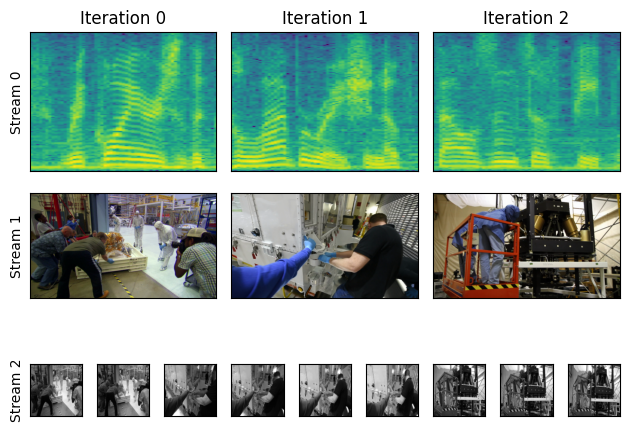

In [11]:
k = 3
fig = plt.figure()
gs = fig.add_gridspec(3, k * n_ite)
for i, waveform in enumerate(waveforms):
    ax = fig.add_subplot(gs[0, k * i : k * (i + 1)])
    ax.specgram(waveform[:, 0], Fs=8000)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title(f"Iteration {i}")
    if i == 0:
        ax.set_ylabel("Stream 0")
for i, vid in enumerate(vids1):
    ax = fig.add_subplot(gs[1, k * i : k * (i + 1)])
    ax.imshow(vid[0].permute(1, 2, 0))  # NCHW->HWC
    ax.set_yticks([])
    ax.set_xticks([])
    if i == 0:
        ax.set_ylabel("Stream 1")
for i, vid in enumerate(vids2):
    for j in range(3):
        ax = fig.add_subplot(gs[2, k * i + j : k * i + j + 1])
        ax.imshow(vid[j].permute(1, 2, 0), cmap="gray")
        ax.set_yticks([])
        ax.set_xticks([])
        if i == 0 and j == 0:
            ax.set_ylabel("Stream 2")
plt.tight_layout()

Tag: :obj:`torchaudio.io`

